# Decision Trees Explained Visually

This notebook explains **decision trees for classification** using simple code and clear plots.

You will learn:
- What a decision tree is
- How a tree splits the feature space into regions
- How depth and other settings control model complexity
- How overfitting happens and how to reduce it
- How to read a tree diagram and feature importances

We will:
- Build small, visual examples
- Use both synthetic data and a real dataset
- Keep the math light and focus on **intuition plus pictures**.

Run the cells from top to bottom. All code is self-contained and ready for Kaggle.

In [2]:
# Basic setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons, load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Plotting style
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries imported.")

Libraries imported.


## Helper: function to plot decision boundaries

To understand trees visually, we will draw **decision regions**:

- The plane is split into colored areas (one color per class).
- The training points are plotted on top.

The function below is just a utility for plotting. You do not need to memorize it; we will use it several times.

In [3]:
def plot_decision_boundary(clf, X, y, ax=None, title=None, h=0.02, cmap=plt.cm.coolwarm):
    """Plot decision boundary for a 2D classifier.

    Parameters
    ----------
    clf : fitted classifier with .predict
    X   : array of shape (n_samples, 2)
    y   : array of shape (n_samples,)
    ax  : matplotlib Axes (optional)
    title : str, title for the plot
    h   : float, step size in the mesh
    """
    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor="k")

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    if title is not None:
        ax.set_title(title)

    return ax

print("Helper function defined.")

Helper function defined.


## 1. A simple 2D toy dataset

To get clean pictures, we start with a **small synthetic dataset**:

- Two input features (can be drawn on a 2D plane).
- Two classes that are not linearly separable.

This makes it easy to see how the tree cuts the plane into regions.

Shape of X: (400, 2)
Shape of y: (400,)


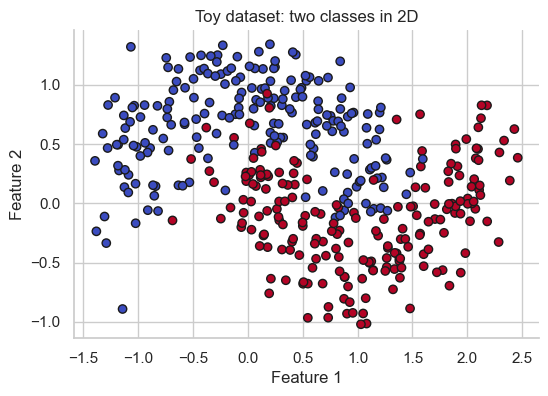

In [4]:
# Generate a 2D toy dataset (two interleaving half circles)
X, y = make_moons(n_samples=400, noise=0.25, random_state=RANDOM_STATE)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Plot the raw data
fig, ax = plt.subplots()
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolor="k")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_title("Toy dataset: two classes in 2D")
plt.show()

## 2. First tree: a very shallow model

We start with a **decision stump** (tree of depth 1):

- Only one split.
- The whole space is divided into two rectangles.

This is an extremely simple model, but the picture is easy to understand.

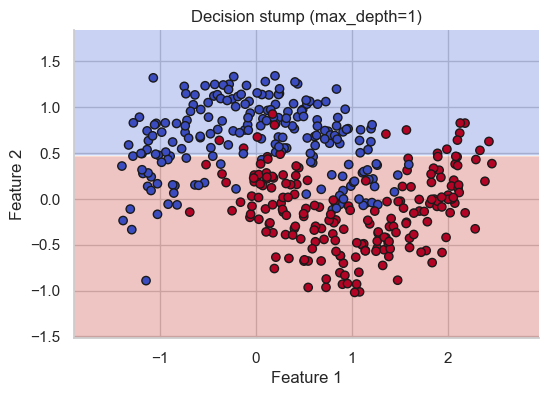

Tree depth: 1
Number of leaves: 2


In [5]:
# Train a very shallow tree (depth = 1)
stump = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE)
stump.fit(X, y)

fig, ax = plt.subplots()
plot_decision_boundary(stump, X, y, ax=ax, title="Decision stump (max_depth=1)")
plt.show()

print("Tree depth:", stump.get_depth())
print("Number of leaves:", stump.get_n_leaves())

## 3. Deeper trees: more flexible decision boundaries

To fit the curved shape of the data, we allow deeper trees:

- Larger `max_depth` means more splits.
- More splits mean more, smaller rectangles in the plane.

Below we compare several depths side by side.

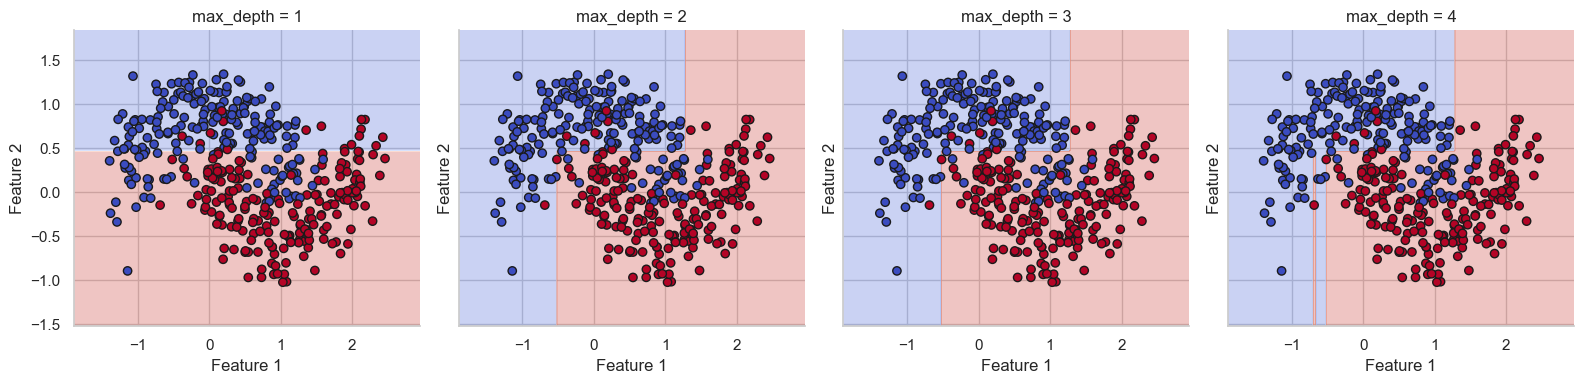

In [6]:
depth_values = [1, 2, 3, 4]

fig, axes = plt.subplots(1, len(depth_values), figsize=(4 * len(depth_values), 4), sharex=True, sharey=True)

for depth, ax in zip(depth_values, axes):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    clf.fit(X, y)
    plot_decision_boundary(clf, X, y, ax=ax, title=f"max_depth = {depth}")

plt.tight_layout()
plt.show()

## 4. How does a tree decide where to split?

At each node, the tree tries many possible splits and picks the one that makes the **child nodes more pure**.

For classification, a common impurity measure is **Gini impurity**:

- If all samples in a node belong to one class, impurity is 0 (perfectly pure).
- If classes are mixed, impurity is higher.

We will compute Gini impurity for a tiny example to see the idea numerically.

In [7]:
def gini_impurity(labels):
    """Compute Gini impurity for a 1D array of class labels."""
    labels = np.array(labels)
    if labels.size == 0:
        return 0.0
    _, counts = np.unique(labels, return_counts=True)
    probs = counts / counts.sum()
    return 1.0 - np.sum(probs ** 2)

# Tiny example: 10 samples, binary classes
example_labels = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
print("Labels:", example_labels)
print("Gini impurity:", gini_impurity(example_labels))

# If all labels are the same, impurity is 0
all_same = np.zeros(10)
print("All same labels:", all_same.astype(int))
print("Gini impurity (all same):", gini_impurity(all_same))

Labels: [0 0 0 0 0 1 1 1 1 1]
Gini impurity: 0.5
All same labels: [0 0 0 0 0 0 0 0 0 0]
Gini impurity (all same): 0.0


### Example: comparing two possible splits

Imagine a parent node with 10 samples, 5 of each class.

We consider two different ways to split it into left and right child nodes. We can compute:

- Impurity of the parent node.
- Impurity of each child node.
- **Weighted average impurity after the split**.

The tree chooses the split that gives the **lowest weighted impurity** (or equivalently the largest impurity decrease).

In [8]:
def weighted_gini(left, right):
    n_left, n_right = len(left), len(right)
    n_total = n_left + n_right
    return (n_left / n_total) * gini_impurity(left) + (n_right / n_total) * gini_impurity(right)

parent = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])  # 5 zeros, 5 ones
print("Parent labels:", parent)
print("Parent Gini:", gini_impurity(parent))

# Split A: [0, 0, 0, 0, 0] | [1, 1, 1, 1, 1]
left_A = parent[:5]
right_A = parent[5:]
print("Split A - left labels:", left_A)
print("Split A - right labels:", right_A)
print("Split A - weighted Gini:", weighted_gini(left_A, right_A))

# Split B: [0, 0, 0, 1, 1] | [0, 1, 1, 1, 1]
left_B = np.array([0, 0, 0, 1, 1])
right_B = np.array([0, 1, 1, 1, 1])
print("\nSplit B - left labels:", left_B)
print("Split B - right labels:", right_B)
print("Split B - weighted Gini:", weighted_gini(left_B, right_B))

Parent labels: [0 0 0 0 0 1 1 1 1 1]
Parent Gini: 0.5
Split A - left labels: [0 0 0 0 0]
Split A - right labels: [1 1 1 1 1]
Split A - weighted Gini: 0.0

Split B - left labels: [0 0 0 1 1]
Split B - right labels: [0 1 1 1 1]
Split B - weighted Gini: 0.3999999999999999


## 5. Overfitting: when trees become too complex

A very deep tree can memorize the training data perfectly, but fail on new data. This is called **overfitting**.

To demonstrate this, we split the data into training and test sets, then train trees with different depths and compare their performance on both sets.

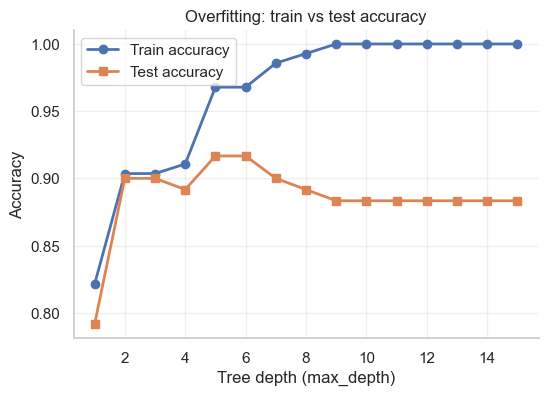

As depth increases:
- Train accuracy keeps improving (model memorizes training data)
- Test accuracy peaks then drops (model overfits)


In [9]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Train trees with different depths
depths = range(1, 16)
train_scores = []
test_scores = []

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

# Plot train vs test accuracy
fig, ax = plt.subplots()
ax.plot(depths, train_scores, marker='o', label='Train accuracy', linewidth=2)
ax.plot(depths, test_scores, marker='s', label='Test accuracy', linewidth=2)
ax.set_xlabel('Tree depth (max_depth)')
ax.set_ylabel('Accuracy')
ax.set_title('Overfitting: train vs test accuracy')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print("As depth increases:")
print("- Train accuracy keeps improving (model memorizes training data)")
print("- Test accuracy peaks then drops (model overfits)")

## 6. Real dataset: Iris flowers

Now we use the famous **Iris dataset** to see how decision trees work on real data:

- 150 samples of iris flowers
- 4 features: sepal length, sepal width, petal length, petal width
- 3 classes: Setosa, Versicolor, Virginica

We will visualize the tree structure and see which features are most important.

In [10]:
# Load Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print("Dataset shape:", X_iris.shape)
print("Features:", feature_names)
print("Classes:", target_names)

# Create a DataFrame for easier viewing
df_iris = pd.DataFrame(X_iris, columns=feature_names)
df_iris['species'] = [target_names[i] for i in y_iris]
print("\nFirst few rows:")
print(df_iris.head())

Dataset shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']

First few rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


### Training a tree on Iris data

We train a tree with moderate depth (depth=3) so the structure is readable. Then we visualize the entire tree structure.

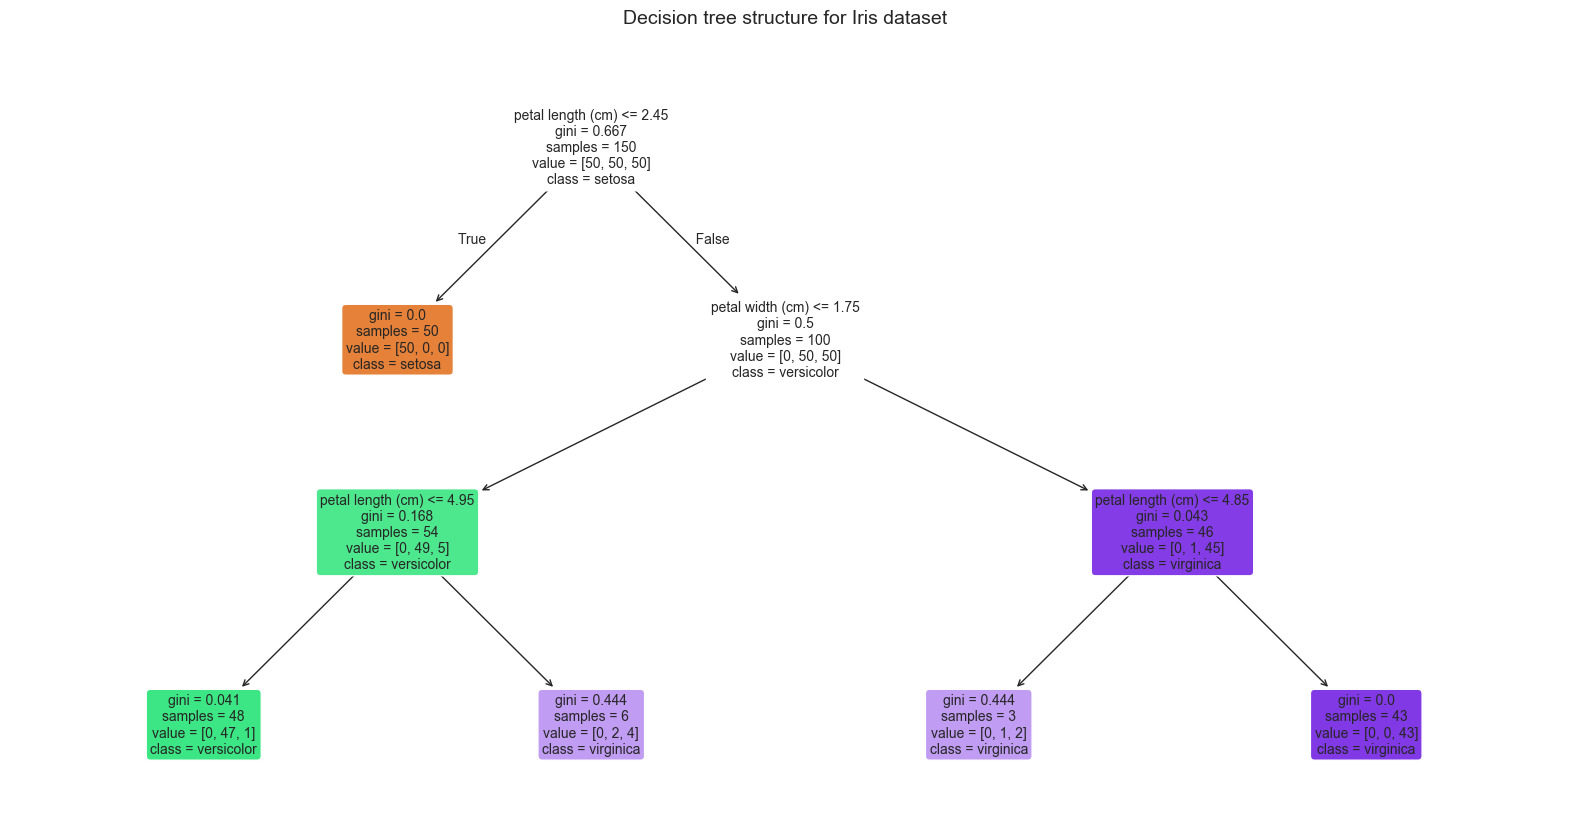

Tree depth: 3
Number of leaves: 5

How to read this tree:
- Each box shows: feature threshold, samples count, value array, predicted class
- Color intensity shows class purity (darker = more pure)
- Follow the arrows: left if condition is true, right if false


In [11]:
# Train a tree on Iris data
iris_tree = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
iris_tree.fit(X_iris, y_iris)

# Visualize the tree structure
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(iris_tree, feature_names=feature_names, class_names=target_names, 
          filled=True, rounded=True, fontsize=10, ax=ax)
plt.title("Decision tree structure for Iris dataset", fontsize=14, pad=20)
plt.show()

print("Tree depth:", iris_tree.get_depth())
print("Number of leaves:", iris_tree.get_n_leaves())
print("\nHow to read this tree:")
print("- Each box shows: feature threshold, samples count, value array, predicted class")
print("- Color intensity shows class purity (darker = more pure)")
print("- Follow the arrows: left if condition is true, right if false")

### Feature importance

Decision trees can tell us which features are most important for making predictions. Features used higher in the tree (closer to the root) or used more frequently tend to have higher importance.

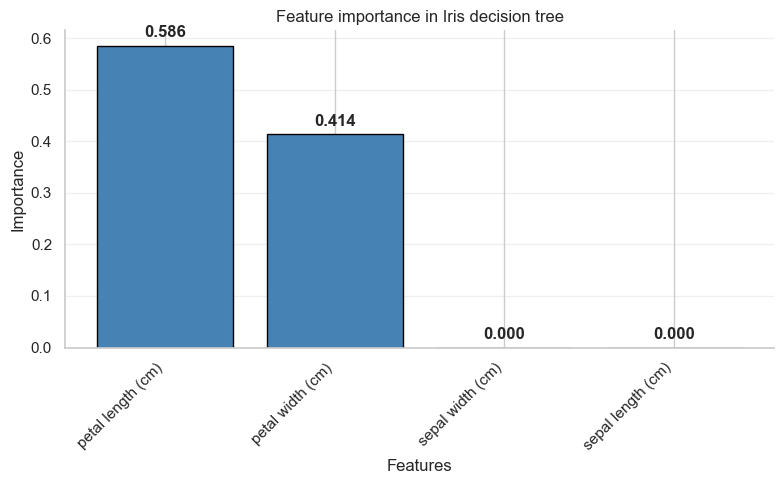

Feature importances:
  petal length (cm): 0.5856
  petal width (cm): 0.4144
  sepal width (cm): 0.0000
  sepal length (cm): 0.0000


In [12]:
# Get feature importances
importances = iris_tree.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(range(len(feature_names)), importances[indices], color='steelblue', edgecolor='black')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature importance in Iris decision tree')
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels([feature_names[i] for i in indices], rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, imp) in enumerate(zip(bars, importances[indices])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{imp:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Feature importances:")
for i in indices:
    print(f"  {feature_names[i]}: {importances[i]:.4f}")

### How a prediction is made: tracing through the tree

To predict a new sample, start at the root node and follow the conditions until you reach a leaf node. The leaf node contains the predicted class.

Let's trace one example through the tree.

In [13]:
# Pick a sample from the dataset
sample_idx = 0
sample = X_iris[sample_idx].reshape(1, -1)
true_label = y_iris[sample_idx]

# Get the decision path
decision_path = iris_tree.decision_path(sample)
node_indicator = decision_path.toarray()[0]

print(f"Sample: {dict(zip(feature_names, X_iris[sample_idx]))}")
print(f"True class: {target_names[true_label]}")
print(f"Predicted class: {target_names[iris_tree.predict(sample)[0]]}")
print("\nDecision path through the tree:")
print("(Node 0 is the root)")

# Show which nodes were visited
leaf_id = iris_tree.apply(sample)[0]
for node_id in np.where(node_indicator == 1)[0]:
    if node_id == iris_tree.tree_.children_left[leaf_id]:
        continue
    if iris_tree.tree_.children_right[leaf_id] == node_id:
        continue
    if node_id == leaf_id:
        print(f"  -> Leaf node {node_id}: predicted class = {target_names[iris_tree.predict(sample)[0]]}")
    else:
        feature_idx = iris_tree.tree_.feature[node_id]
        threshold = iris_tree.tree_.threshold[node_id]
        feature_name = feature_names[feature_idx]
        value = X_iris[sample_idx, feature_idx]
        direction = "left" if value <= threshold else "right"
        print(f"  -> Node {node_id}: {feature_name} <= {threshold:.2f}? (value={value:.2f}) -> go {direction}")

Sample: {'sepal length (cm)': np.float64(5.1), 'sepal width (cm)': np.float64(3.5), 'petal length (cm)': np.float64(1.4), 'petal width (cm)': np.float64(0.2)}
True class: setosa
Predicted class: setosa

Decision path through the tree:
(Node 0 is the root)
  -> Node 0: petal length (cm) <= 2.45? (value=1.40) -> go left
  -> Leaf node 1: predicted class = setosa


## Summary

Decision trees are simple but powerful models for classification:

**Key concepts:**
- Trees split the feature space into rectangular regions
- Each split tries to make child nodes more pure (lower impurity)
- Deeper trees are more flexible but can overfit
- Trees provide interpretable predictions and feature importances

**Important parameters:**
- `max_depth`: controls tree complexity (prevents overfitting)
- `min_samples_split`: minimum samples required to split a node
- `min_samples_leaf`: minimum samples required in a leaf node

**Advantages:**
- Easy to understand and visualize
- No need for feature scaling
- Can handle non-linear relationships
- Provides feature importance scores

**Limitations:**
- Can overfit easily (use regularization)
- Sensitive to small changes in data
- May not generalize as well as ensemble methods (Random Forest, Gradient Boosting)


# Thankyou upvote